In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.model_selection import ParameterGrid

#Darts functions
from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_csv('nyc_data.csv', index_col = 'Date', parse_dates=True)
df = df.asfreq('D')
df.rename(columns={'Demand': 'y'}, inplace=True)
df

,y,Easter,Thanksgiving,Christmas,Temperature,Marketing
Date,,,,,,
2015-01-01,720.000885,0,0,0,3.68,41.305
2015-01-02,581.276773,0,0,0,4.73,131.574
2015-01-03,754.117039,0,0,0,7.23,162.700
2015-01-04,622.252774,0,0,0,10.96,160.281
2015-01-05,785.373319,0,0,0,6.92,51.077
...,...,...,...,...,...,...
2020-12-27,685.915026,0,0,0,2.89,38.674
2020-12-28,998.051170,0,0,0,8.83,166.712
2020-12-29,847.123399,0,0,0,3.48,161.865


Exploratory Data Analysis

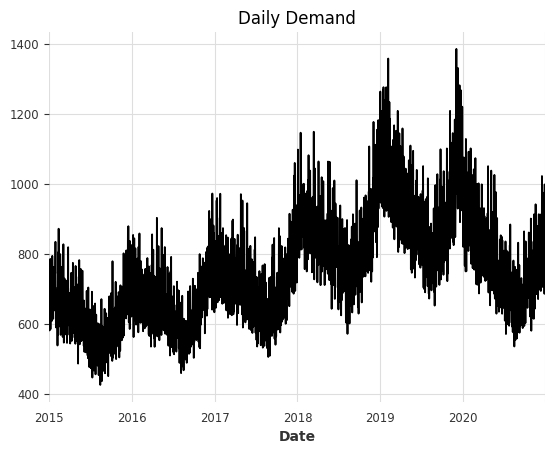

In [4]:
df['y'].plot()
plt.title('Daily Demand');

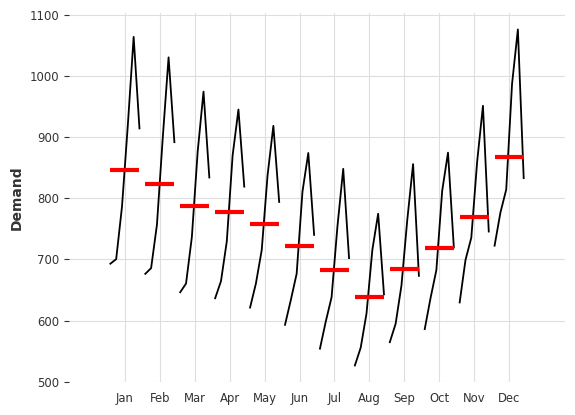

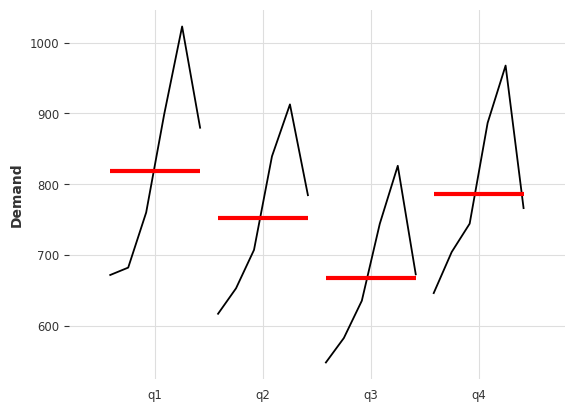

In [5]:
month_plot(df['y'].resample('ME').mean(), ylabel='Demand')
quarter_plot(df['y'].resample('QE').mean(), ylabel='Demand');

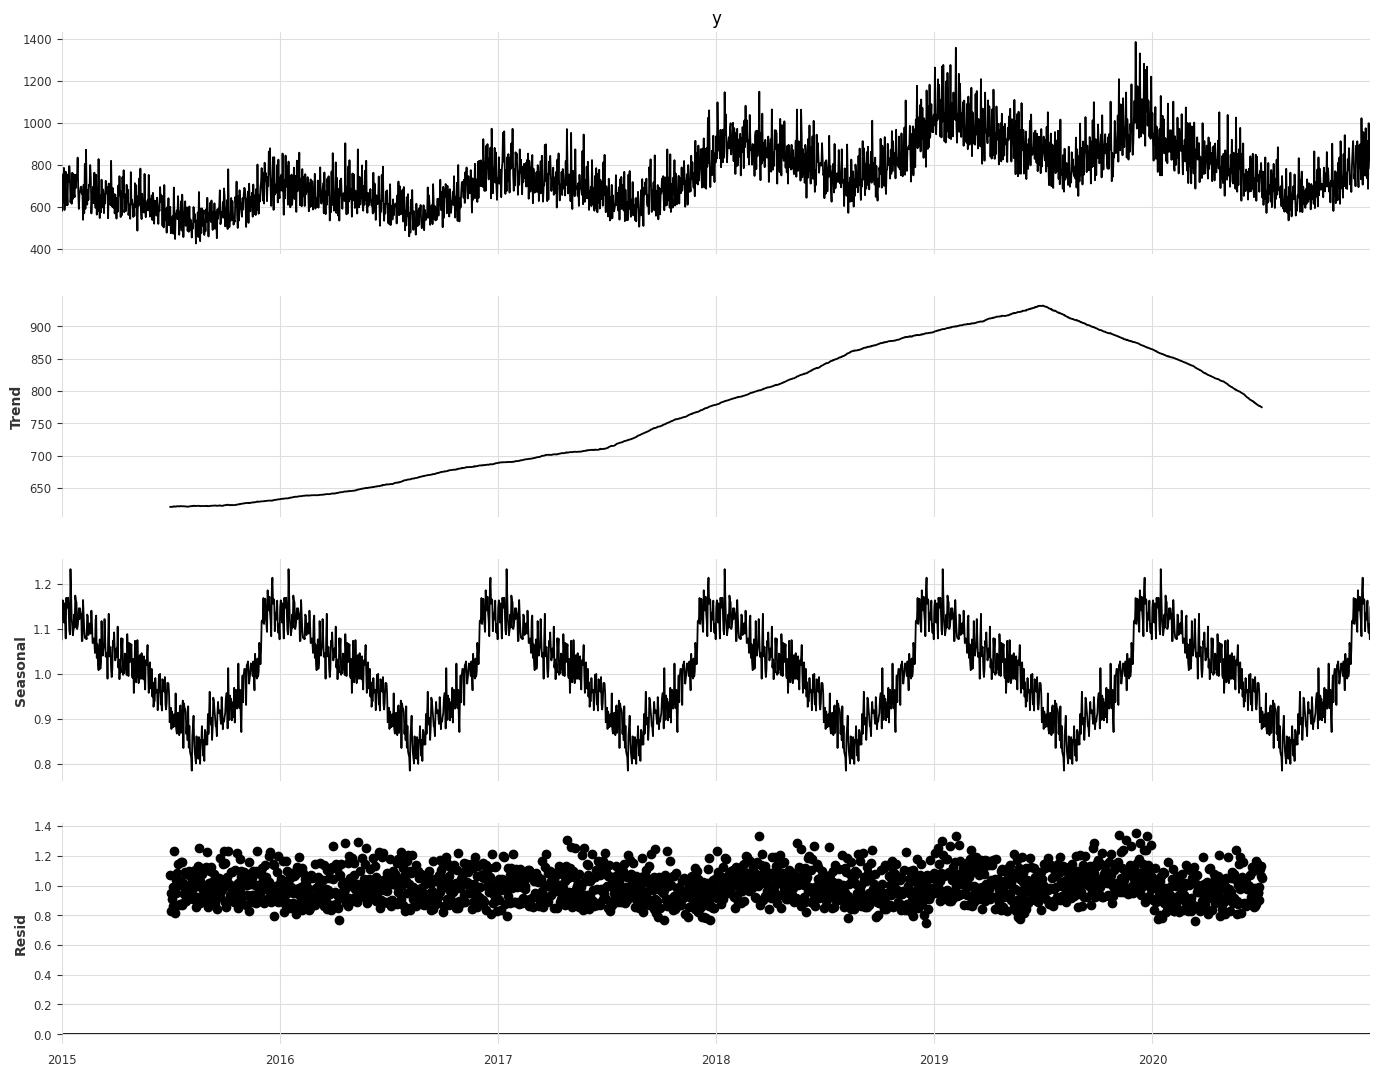

In [6]:
fig = seasonal_decompose(df['y'], model='mul', period=365).plot()
fig.set_size_inches(15,12)
plt.show()

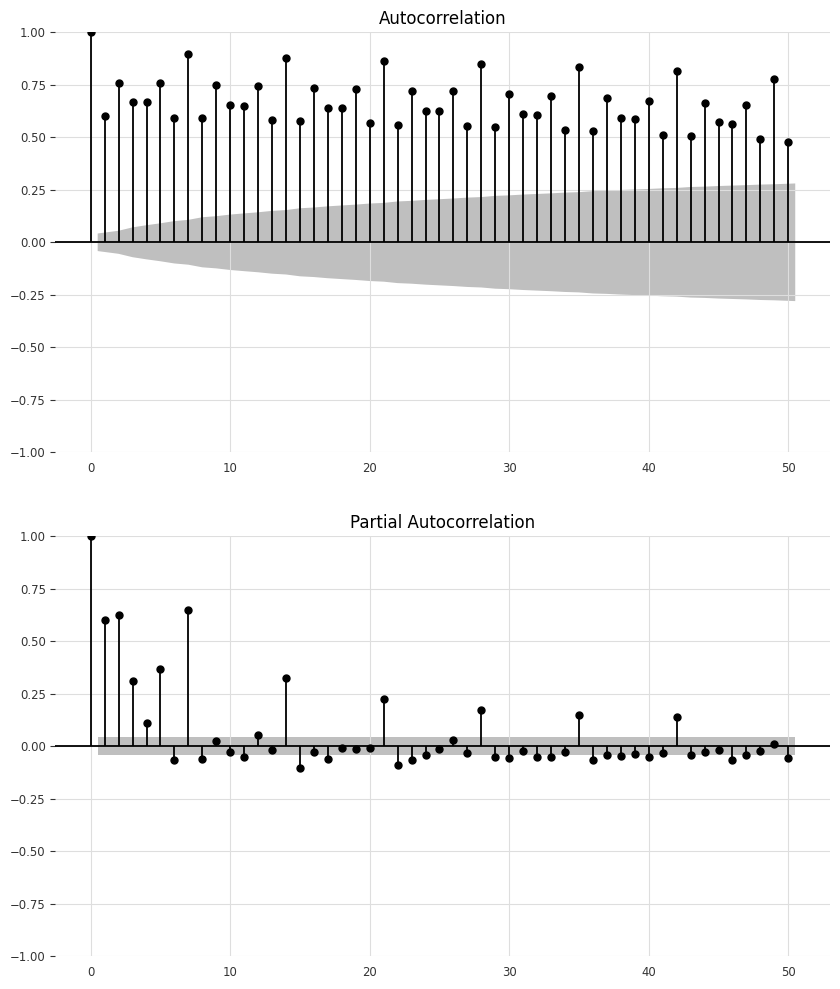

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(10, 12))
plot_acf(df['y'], lags=50, ax=ax[0])
plot_pacf(df['y'], lags=50, ax=ax[1])
plt.show()

Prepare the Model

In [8]:
series = TimeSeries.from_series(df['y'])
covariates = TimeSeries.from_dataframe(df.iloc[:,1:])

In [9]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(),
                  freq = series.freq_str,
                  periods = df.shape[0]),
                attribute = 'year',
                one_hot=False)

month_series = datetime_attribute_timeseries(year_series,
                                             attribute='month',
                                             one_hot=True)

weekday_series = datetime_attribute_timeseries(year_series,
                                               attribute='weekday',
                                               one_hot=True)

In [10]:
scaler_y = Scaler()
scaler_covariates = Scaler()

y_transformed = scaler_y.fit_transform(series)

covariates = covariates.stack(year_series)

covariates_transformed = scaler_covariates.fit_transform(covariates)
covariates_transformed = covariates_transformed.stack(month_series).stack(weekday_series)

In [11]:
forecast_horizon = 31
input_chunk_length = 46

training_length = forecast_horizon + input_chunk_length

In [12]:
model = RNNModel(model = 'LSTM',
                 hidden_dim=20,
                 n_rnn_layers=2,
                 dropout=0.1,
                 n_epochs=10,
                 optimizer_kwargs={'lr': 0.003},
                 random_state=42,
                 training_length=training_length,
                 input_chunk_length=input_chunk_length,
                 pl_trainer_kwargs= {'accelerator': 'gpu',
                                     'devices': [0]})

model.fit(y_transformed, future_covariates=covariates_transformed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | L

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 95.38it/s, train_loss=0.00321] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 95.27it/s, train_loss=0.00321]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=77, n_epochs=10, optimizer_kwargs={'lr': 0.003}, random_state=42, input_chunk_length=46, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

Cross Validation

In [13]:
cv = model.historical_forecasts(series = y_transformed,
                                future_covariates = covariates_transformed,
                                start = df.shape[0] - 180,
                                forecast_horizon = forecast_horizon,
                                stride = 16,
                                retrain=True,
                                last_points_only=False)

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 98.94it/s, train_loss=0.00266] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 98.81it/s, train_loss=0.00266]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 96.96it/s, train_loss=0.00272] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 96.82it/s, train_loss=0.00272]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 98.88it/s, train_loss=0.00302] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 98.77it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 97.84it/s, train_loss=0.00283] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 97.72it/s, train_loss=0.00283]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 97.43it/s, train_loss=0.00297] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 97.31it/s, train_loss=0.00297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 94.46it/s, train_loss=0.00302] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 94.34it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 100.74it/s, train_loss=0.00331]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 100.63it/s, train_loss=0.00331]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 95.04it/s, train_loss=0.00287] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 94.93it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.71it/s, train_loss=0.003]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.58it/s, train_loss=0.003]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.88it/s, train_loss=0.00308]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.78it/s, train_loss=0.00308]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [14]:
rmse_cv = []

for i in range(len(cv)):

    predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

    start = predictions.index.min()
    end = predictions.index.max()

    actuals = df['y'][start:end,]

    error_cv = np.sqrt(mean_squared_error(actuals, predictions))
    rmse_cv.append(error_cv)

print(np.mean(rmse_cv))

101.5223679754953


Tuning

In [15]:
param_grid = {'n_rnn_layers': [1, 2],
              'hidden_dim': [10, 20],
              'dropout': [0.1, 0.2],
              'n_epochs': [5, 10],
              'lr': [0.003],
              'training_length': [77],
              'input_chunk_length': [46]
}

grid = ParameterGrid(param_grid)

In [16]:
rmse = []

for params in grid:

    model = RNNModel(model='LSTM',
                     hidden_dim=params['hidden_dim'],
                     n_rnn_layers=params['n_rnn_layers'],
                     dropout=params['dropout'],
                     n_epochs=params['n_epochs'],
                     optimizer_kwargs = {'lr': params['lr']},
                     random_state=42,
                     training_length=params['training_length'],
                     input_chunk_length=params['input_chunk_length'],
                     pl_trainer_kwargs={'accelerator': 'gpu',
                                        'devices': [0]})
    
    model.fit(y_transformed, future_covariates=covariates_transformed)

    cv = model.historical_forecasts(series = y_transformed,
                                    future_covariates=covariates_transformed,
                                    start= df.shape[0] -180,
                                    forecast_horizon = forecast_horizon,
                                    stride=16,
                                    retrain=True,
                                    last_points_only=False)
    

    rmse_cv = []

    for i in range(len(cv)):
        predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

        start = predictions.index.min()
        end = predictions.index.max()

        actuals = df['y'][start:end,]

        error_cv = root_mean_squared_error(actuals, predictions)

        rmse_cv.append(error_cv)

    error = np.mean(rmse_cv)
    rmse.append(error)


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.5 K  | train
6 | V               | Linear           | 11     | train
---------------------------------------------

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 164.86it/s, train_loss=0.006]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 164.60it/s, train_loss=0.006]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 165.05it/s, train_loss=0.00419]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 164.71it/s, train_loss=0.00419]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 164.77it/s, train_loss=0.005]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 164.42it/s, train_loss=0.005]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 161.17it/s, train_loss=0.00315]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 160.87it/s, train_loss=0.00315]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 161.44it/s, train_loss=0.00466]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 161.13it/s, train_loss=0.00466]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 165.92it/s, train_loss=0.00543]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 165.60it/s, train_loss=0.00543]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 164.85it/s, train_loss=0.0054] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 164.55it/s, train_loss=0.0054]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 165.24it/s, train_loss=0.00418]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 164.84it/s, train_loss=0.00418]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 164.37it/s, train_loss=0.00571]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 164.09it/s, train_loss=0.00571]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 162.78it/s, train_loss=0.00458]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 162.51it/s, train_loss=0.00458]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 156.40it/s, train_loss=0.00552]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 156.14it/s, train_loss=0.00552]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 119.92it/s, train_loss=0.00251]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 119.78it/s, train_loss=0.00251]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | trai

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 119.68it/s, train_loss=0.00289]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 119.51it/s, train_loss=0.00289]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 120.00it/s, train_loss=0.00328]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 119.82it/s, train_loss=0.00328]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 118.23it/s, train_loss=0.00354]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 118.04it/s, train_loss=0.00354]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 117.95it/s, train_loss=0.00321]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 117.78it/s, train_loss=0.00321]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 119.56it/s, train_loss=0.00322]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 119.41it/s, train_loss=0.00322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 118.07it/s, train_loss=0.00317]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 117.90it/s, train_loss=0.00317]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.94it/s, train_loss=0.00291]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.80it/s, train_loss=0.00291]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.98it/s, train_loss=0.00322]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.80it/s, train_loss=0.00322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 119.85it/s, train_loss=0.00293]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 119.65it/s, train_loss=0.00293]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 116.43it/s, train_loss=0.00357]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 116.24it/s, train_loss=0.00357]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 164.61it/s, train_loss=0.00392]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 164.30it/s, train_loss=0.00392]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.5 K  | train
6 | V               | Linear           | 11     | train
---------------------------------------------

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 165.33it/s, train_loss=0.00312]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 165.03it/s, train_loss=0.00312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 165.19it/s, train_loss=0.00411]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 164.87it/s, train_loss=0.00411]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 165.53it/s, train_loss=0.00471]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 165.23it/s, train_loss=0.00471]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 162.84it/s, train_loss=0.00481]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 162.45it/s, train_loss=0.00481]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 162.36it/s, train_loss=0.00345]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 162.09it/s, train_loss=0.00345]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 163.08it/s, train_loss=0.00402]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 162.76it/s, train_loss=0.00402]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 166.41it/s, train_loss=0.0047] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 166.13it/s, train_loss=0.0047]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 164.85it/s, train_loss=0.00375]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 164.54it/s, train_loss=0.00375]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 165.06it/s, train_loss=0.00416]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 164.75it/s, train_loss=0.00416]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 164.48it/s, train_loss=0.00372]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 164.13it/s, train_loss=0.00372]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 119.98it/s, train_loss=0.00228]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 119.81it/s, train_loss=0.00228]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | trai

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 119.83it/s, train_loss=0.00236]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 119.67it/s, train_loss=0.00236]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 119.79it/s, train_loss=0.00284]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 119.61it/s, train_loss=0.00284]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 119.77it/s, train_loss=0.00282]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 119.60it/s, train_loss=0.00282]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 119.84it/s, train_loss=0.00263]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 119.69it/s, train_loss=0.00263]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 123.79it/s, train_loss=0.00272]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 123.60it/s, train_loss=0.00272]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 119.84it/s, train_loss=0.00264]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 119.63it/s, train_loss=0.00264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 120.16it/s, train_loss=0.00295]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 120.00it/s, train_loss=0.00295]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 120.37it/s, train_loss=0.00276]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 120.19it/s, train_loss=0.00276]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 121.81it/s, train_loss=0.00258]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 121.64it/s, train_loss=0.00258]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 118.18it/s, train_loss=0.00297]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 118.01it/s, train_loss=0.00297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 134.34it/s, train_loss=0.00192]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 134.15it/s, train_loss=0.00192]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 134.02it/s, train_loss=0.00344]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 133.77it/s, train_loss=0.00344]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 134.80it/s, train_loss=0.00292]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 134.54it/s, train_loss=0.00292]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 136.15it/s, train_loss=0.00382]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 135.93it/s, train_loss=0.00382]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 133.56it/s, train_loss=0.00252]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 133.31it/s, train_loss=0.00252]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 134.20it/s, train_loss=0.00287]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 134.01it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 133.25it/s, train_loss=0.00302]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 133.04it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 132.77it/s, train_loss=0.00246]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 132.58it/s, train_loss=0.00246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 131.31it/s, train_loss=0.00264]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 131.13it/s, train_loss=0.00264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 135.71it/s, train_loss=0.00353]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 135.52it/s, train_loss=0.00353]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 134.48it/s, train_loss=0.0033] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 134.25it/s, train_loss=0.0033]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 100.49it/s, train_loss=0.00438]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 100.36it/s, train_loss=0.00438]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Tota

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 100.44it/s, train_loss=0.00406]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 100.32it/s, train_loss=0.00406]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 99.90it/s, train_loss=0.00426] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 99.76it/s, train_loss=0.00426]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.35it/s, train_loss=0.00359]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.24it/s, train_loss=0.00359]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.69it/s, train_loss=0.00412]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.56it/s, train_loss=0.00412]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 99.99it/s, train_loss=0.00391] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 99.85it/s, train_loss=0.00391]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 99.92it/s, train_loss=0.0038]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 99.79it/s, train_loss=0.0038]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 100.31it/s, train_loss=0.00345]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 100.18it/s, train_loss=0.00345]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 101.48it/s, train_loss=0.0037] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 101.36it/s, train_loss=0.0037]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 101.47it/s, train_loss=0.00369]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 101.35it/s, train_loss=0.00369]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 98.39it/s, train_loss=0.00347] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 98.27it/s, train_loss=0.00347]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 134.57it/s, train_loss=0.00149]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 134.37it/s, train_loss=0.00149]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.8 K  | train
6 | V               | Linear           | 21     | train
---------------------------------------------

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 130.27it/s, train_loss=0.00326]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 130.09it/s, train_loss=0.00326]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 134.20it/s, train_loss=0.0026] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 134.01it/s, train_loss=0.0026]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 134.04it/s, train_loss=0.00215]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 133.82it/s, train_loss=0.00215]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 133.26it/s, train_loss=0.00279]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 133.05it/s, train_loss=0.00279]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 134.76it/s, train_loss=0.0023] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 134.50it/s, train_loss=0.0023]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 130.65it/s, train_loss=0.00256]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 130.42it/s, train_loss=0.00256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 134.64it/s, train_loss=0.00221]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 134.45it/s, train_loss=0.00221]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 134.02it/s, train_loss=0.00243]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 133.80it/s, train_loss=0.00243]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 134.36it/s, train_loss=0.00225]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 134.16it/s, train_loss=0.00225]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 132.35it/s, train_loss=0.00257]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 132.16it/s, train_loss=0.00257]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 101.08it/s, train_loss=0.00321]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 100.97it/s, train_loss=0.00321]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 101.92it/s, train_loss=0.00266]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 101.80it/s, train_loss=0.00266]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 101.32it/s, train_loss=0.00272]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 101.19it/s, train_loss=0.00272]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 100.54it/s, train_loss=0.00302]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 100.42it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 101.50it/s, train_loss=0.00283]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 101.37it/s, train_loss=0.00283]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 100.94it/s, train_loss=0.00297]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 100.84it/s, train_loss=0.00297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 99.93it/s, train_loss=0.00302] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 99.83it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 99.79it/s, train_loss=0.00331] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 99.68it/s, train_loss=0.00331]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 100.84it/s, train_loss=0.00287]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 100.68it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.13it/s, train_loss=0.003]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.02it/s, train_loss=0.003]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.25it/s, train_loss=0.00308]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.14it/s, train_loss=0.00308]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 164.55it/s, train_loss=0.006]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 164.28it/s, train_loss=0.006]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 1.5 K  | train
6 | V               | Linear           | 11     | train
---------------------------------------------

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 164.98it/s, train_loss=0.00419]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 164.68it/s, train_loss=0.00419]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 164.31it/s, train_loss=0.005]  

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 163.98it/s, train_loss=0.005]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 164.62it/s, train_loss=0.00315]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 164.31it/s, train_loss=0.00315]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 163.28it/s, train_loss=0.00466]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 162.97it/s, train_loss=0.00466]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 163.00it/s, train_loss=0.00543]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 162.65it/s, train_loss=0.00543]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 165.98it/s, train_loss=0.0054] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 165.64it/s, train_loss=0.0054]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 165.01it/s, train_loss=0.00418]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 164.68it/s, train_loss=0.00418]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 164.88it/s, train_loss=0.00571]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 164.56it/s, train_loss=0.00571]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 164.99it/s, train_loss=0.00458]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 164.68it/s, train_loss=0.00458]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 162.24it/s, train_loss=0.00552]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 161.93it/s, train_loss=0.00552]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 122.02it/s, train_loss=0.00277]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 121.87it/s, train_loss=0.00277]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Tota

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 120.09it/s, train_loss=0.00309]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 119.89it/s, train_loss=0.00309]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 119.88it/s, train_loss=0.00369]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 119.70it/s, train_loss=0.00369]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 119.83it/s, train_loss=0.00385]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 119.63it/s, train_loss=0.00385]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 118.53it/s, train_loss=0.0035] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 118.36it/s, train_loss=0.0035]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 119.93it/s, train_loss=0.00351]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 119.76it/s, train_loss=0.00351]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 119.76it/s, train_loss=0.00352]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 119.59it/s, train_loss=0.00352]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.01it/s, train_loss=0.00318]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 118.86it/s, train_loss=0.00318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.48it/s, train_loss=0.00346]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 119.29it/s, train_loss=0.00346]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 119.88it/s, train_loss=0.00323]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 119.70it/s, train_loss=0.00323]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 119.73it/s, train_loss=0.00398]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 119.59it/s, train_loss=0.00398]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 164.86it/s, train_loss=0.00392]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 164.56it/s, train_loss=0.00392]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 164.54it/s, train_loss=0.00312]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 164.21it/s, train_loss=0.00312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 165.29it/s, train_loss=0.00411]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 164.99it/s, train_loss=0.00411]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 164.80it/s, train_loss=0.00471]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 164.48it/s, train_loss=0.00471]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 164.75it/s, train_loss=0.00481]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 164.43it/s, train_loss=0.00481]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 164.73it/s, train_loss=0.00345]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 164.45it/s, train_loss=0.00345]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 165.51it/s, train_loss=0.00402]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 165.22it/s, train_loss=0.00402]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 162.81it/s, train_loss=0.0047] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 162.52it/s, train_loss=0.0047]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 164.29it/s, train_loss=0.00375]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 163.97it/s, train_loss=0.00375]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 165.01it/s, train_loss=0.00416]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 164.69it/s, train_loss=0.00416]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 164.94it/s, train_loss=0.00372]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 164.67it/s, train_loss=0.00372]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 120.13it/s, train_loss=0.00255]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 119.93it/s, train_loss=0.00255]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | trai

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 119.87it/s, train_loss=0.00256]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 119.68it/s, train_loss=0.00256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 118.87it/s, train_loss=0.00305]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 118.70it/s, train_loss=0.00305]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 119.88it/s, train_loss=0.00306]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 119.72it/s, train_loss=0.00306]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 117.79it/s, train_loss=0.00284]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 117.59it/s, train_loss=0.00284]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 119.99it/s, train_loss=0.00288]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 119.82it/s, train_loss=0.00288]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 119.49it/s, train_loss=0.00292]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 119.32it/s, train_loss=0.00292]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 119.67it/s, train_loss=0.00312]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 119.50it/s, train_loss=0.00312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 119.95it/s, train_loss=0.00298]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 119.78it/s, train_loss=0.00298]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 121.25it/s, train_loss=0.00276]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 121.08it/s, train_loss=0.00276]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 2.4 K  | train
6 | V               | Linear           | 11     | train
-------------------------------------------------------------
2.4 K     Trainable params
0         Non-trainable params
2.4 K     Total params
0.010     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 119.96it/s, train_loss=0.00322]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 119.79it/s, train_loss=0.00322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 132.35it/s, train_loss=0.00192]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 132.15it/s, train_loss=0.00192]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 3.8 K  | train
6 | V               | Linear           | 21     | train
---------------------------------------------

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 133.76it/s, train_loss=0.00344]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 133.53it/s, train_loss=0.00344]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 133.31it/s, train_loss=0.00292]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 133.10it/s, train_loss=0.00292]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 133.39it/s, train_loss=0.00382]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 133.19it/s, train_loss=0.00382]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 134.45it/s, train_loss=0.00252]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 134.25it/s, train_loss=0.00252]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 129.88it/s, train_loss=0.00287]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 129.68it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 134.32it/s, train_loss=0.00302]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 134.09it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 134.37it/s, train_loss=0.00246]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 134.11it/s, train_loss=0.00246]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 132.77it/s, train_loss=0.00264]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 132.53it/s, train_loss=0.00264]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 135.63it/s, train_loss=0.00353]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 135.41it/s, train_loss=0.00353]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 130.05it/s, train_loss=0.0033] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 129.87it/s, train_loss=0.0033]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 101.22it/s, train_loss=0.00478]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 67/67 [00:00<00:00, 101.12it/s, train_loss=0.00478]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 100.44it/s, train_loss=0.00439]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 100.32it/s, train_loss=0.00439]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 99.49it/s, train_loss=0.00469] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 61/61 [00:00<00:00, 99.37it/s, train_loss=0.00469]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.53it/s, train_loss=0.00385]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.42it/s, train_loss=0.00385]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.90it/s, train_loss=0.0045] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 62/62 [00:00<00:00, 100.77it/s, train_loss=0.0045]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 101.62it/s, train_loss=0.00421]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 101.47it/s, train_loss=0.00421]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 101.00it/s, train_loss=0.00415]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 63/63 [00:00<00:00, 100.88it/s, train_loss=0.00415]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 101.27it/s, train_loss=0.00374]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 101.15it/s, train_loss=0.00374]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 100.67it/s, train_loss=0.00406]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 64/64 [00:00<00:00, 100.54it/s, train_loss=0.00406]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 101.16it/s, train_loss=0.00386]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 101.04it/s, train_loss=0.00386]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 102.38it/s, train_loss=0.00383]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 65/65 [00:00<00:00, 102.26it/s, train_loss=0.00383]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 135.26it/s, train_loss=0.00149]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 135.01it/s, train_loss=0.00149]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 134.43it/s, train_loss=0.00326]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 134.19it/s, train_loss=0.00326]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 134.56it/s, train_loss=0.0026] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 134.31it/s, train_loss=0.0026]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 132.68it/s, train_loss=0.00215]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 132.47it/s, train_loss=0.00215]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 133.81it/s, train_loss=0.00279]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 133.55it/s, train_loss=0.00279]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 132.90it/s, train_loss=0.0023] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 132.70it/s, train_loss=0.0023]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 132.87it/s, train_loss=0.00256]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 132.66it/s, train_loss=0.00256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 129.28it/s, train_loss=0.00221]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 129.11it/s, train_loss=0.00221]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 133.44it/s, train_loss=0.00243]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 133.25it/s, train_loss=0.00243]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 134.58it/s, train_loss=0.00225]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 134.38it/s, train_loss=0.00225]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/salgado/scripts/time_series/.venv/lib64/python3.12/site-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 133.94it/s, train_loss=0.00257]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 133.74it/s, train_loss=0.00257]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 99.50it/s, train_loss=0.00356] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 67/67 [00:00<00:00, 99.39it/s, train_loss=0.00356]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Tota

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 99.69it/s, train_loss=0.00285] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 99.57it/s, train_loss=0.00285]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 98.94it/s, train_loss=0.00295] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 61/61 [00:00<00:00, 98.82it/s, train_loss=0.00295]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 99.95it/s, train_loss=0.0032]  

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 99.83it/s, train_loss=0.0032]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 100.06it/s, train_loss=0.00303]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 62/62 [00:00<00:00, 99.92it/s, train_loss=0.00303] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 99.87it/s, train_loss=0.00308] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 99.75it/s, train_loss=0.00308]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 98.89it/s, train_loss=0.00322] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 63/63 [00:00<00:00, 98.77it/s, train_loss=0.00322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 100.93it/s, train_loss=0.0036] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 100.81it/s, train_loss=0.0036]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 98.92it/s, train_loss=0.00306] 

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 64/64 [00:00<00:00, 98.81it/s, train_loss=0.00306]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.41it/s, train_loss=0.00319]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.29it/s, train_loss=0.00319]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 100.04it/s, train_loss=0.00322]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 65/65 [00:00<00:00, 99.90it/s, train_loss=0.00322] 


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [17]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
min_rmse = min(rmse)

best_params = tuning_results.query('rmse == @min_rmse')
best_params

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
15,0.2,20,46,0.003,10,2,77,99.141092


In [45]:
param_grid = {'n_rnn_layers': [2],
              'hidden_dim': [20],
              'input_chunk_length': [46],
              'dropout': [0.2],
              'n_epochs': [15, 18, 20, 25],
              'lr': [0.002, 0.0015, 0.001],
              'training_length': [60]}

grid = ParameterGrid(param_grid)
len(grid)

12

In [46]:
rmse = []

for params in grid:

    model = RNNModel(model='LSTM',
                     hidden_dim=params['hidden_dim'],
                     n_rnn_layers=params['n_rnn_layers'],
                     dropout=params['dropout'],
                     n_epochs=params['n_epochs'],
                     optimizer_kwargs = {'lr': params['lr']},
                     random_state=42,
                     training_length=params['training_length'],
                     input_chunk_length=params['input_chunk_length'],
                     pl_trainer_kwargs={'accelerator': 'gpu',
                                        'devices': [0]})
    
    model.fit(y_transformed, future_covariates=covariates_transformed)

    cv = model.historical_forecasts(series = y_transformed,
                                    future_covariates=covariates_transformed,
                                    start= df.shape[0] -180,
                                    forecast_horizon = forecast_horizon,
                                    stride=16,
                                    retrain=True,
                                    last_points_only=False)
    

    rmse_cv = []

    for i in range(len(cv)):
        predictions = TimeSeries.pd_series(scaler_y.inverse_transform(cv[i]))

        start = predictions.index.min()
        end = predictions.index.max()

        actuals = df['y'][start:end,]
        error_cv = root_mean_squared_error(actuals, predictions)

        rmse_cv.append(error_cv)

    error = np.mean(rmse_cv)
    rmse.append(error)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 119.81it/s, train_loss=0.00313]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 119.61it/s, train_loss=0.00313]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 14: 100%|██████████| 61/61 [00:00<00:00, 120.92it/s, train_loss=0.00324]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 61/61 [00:00<00:00, 120.70it/s, train_loss=0.00324]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 120.08it/s, train_loss=0.00372]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 119.91it/s, train_loss=0.00372]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 123.08it/s, train_loss=0.00364]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 122.92it/s, train_loss=0.00364]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 120.08it/s, train_loss=0.0029] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 119.91it/s, train_loss=0.0029]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 119.72it/s, train_loss=0.00309]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 119.56it/s, train_loss=0.00309]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 122.92it/s, train_loss=0.00297]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 122.70it/s, train_loss=0.00297]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 120.02it/s, train_loss=0.00291]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 119.86it/s, train_loss=0.00291]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 123.03it/s, train_loss=0.00287]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 122.86it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 120.10it/s, train_loss=0.00279]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 119.94it/s, train_loss=0.00279]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 66/66 [00:00<00:00, 122.60it/s, train_loss=0.00314]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 66/66 [00:00<00:00, 122.45it/s, train_loss=0.00314]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 121.32it/s, train_loss=0.00317]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 121.16it/s, train_loss=0.00317]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 17: 100%|██████████| 61/61 [00:00<00:00, 121.76it/s, train_loss=0.00276]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 61/61 [00:00<00:00, 121.60it/s, train_loss=0.00276]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 123.35it/s, train_loss=0.0031] 

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 123.18it/s, train_loss=0.0031]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 120.01it/s, train_loss=0.00292]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 119.85it/s, train_loss=0.00292]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 120.19it/s, train_loss=0.00287]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 119.99it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 119.93it/s, train_loss=0.00293]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 119.70it/s, train_loss=0.00293]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 119.97it/s, train_loss=0.00272]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 119.82it/s, train_loss=0.00272]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 119.93it/s, train_loss=0.00299]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 119.74it/s, train_loss=0.00299]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 122.75it/s, train_loss=0.00326]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 122.57it/s, train_loss=0.00326]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 122.17it/s, train_loss=0.00301]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 121.98it/s, train_loss=0.00301]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 66/66 [00:00<00:00, 122.01it/s, train_loss=0.00311]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 66/66 [00:00<00:00, 121.82it/s, train_loss=0.00311]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 119.68it/s, train_loss=0.00285]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 119.48it/s, train_loss=0.00285]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 120.79it/s, train_loss=0.00358]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 120.61it/s, train_loss=0.00358]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 123.77it/s, train_loss=0.00318]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 123.58it/s, train_loss=0.00318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 123.36it/s, train_loss=0.00305]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 123.10it/s, train_loss=0.00305]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 123.02it/s, train_loss=0.0029] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 122.85it/s, train_loss=0.0029]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 122.11it/s, train_loss=0.00267]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 121.95it/s, train_loss=0.00267]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 119.93it/s, train_loss=0.00303]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 119.77it/s, train_loss=0.00303]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 120.32it/s, train_loss=0.00287]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 120.12it/s, train_loss=0.00287]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 119.56it/s, train_loss=0.00274]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 119.41it/s, train_loss=0.00274]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 118.14it/s, train_loss=0.00275]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 117.98it/s, train_loss=0.00275]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 123.99it/s, train_loss=0.00308]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 123.81it/s, train_loss=0.00308]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 120.34it/s, train_loss=0.00316]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 120.19it/s, train_loss=0.00316]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 61/61 [00:00<00:00, 119.90it/s, train_loss=0.00276]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 61/61 [00:00<00:00, 119.74it/s, train_loss=0.00276]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 120.00it/s, train_loss=0.00285]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 119.86it/s, train_loss=0.00285]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 123.79it/s, train_loss=0.0026] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 123.59it/s, train_loss=0.0026]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 119.85it/s, train_loss=0.00263]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 119.69it/s, train_loss=0.00263]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 122.17it/s, train_loss=0.00265]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 122.01it/s, train_loss=0.00265]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 123.96it/s, train_loss=0.00341]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 123.80it/s, train_loss=0.00341]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 118.00it/s, train_loss=0.00245]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 117.84it/s, train_loss=0.00245]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 120.14it/s, train_loss=0.00232]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.96it/s, train_loss=0.00232]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.86it/s, train_loss=0.00257]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.68it/s, train_loss=0.00257]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 66/66 [00:00<00:00, 122.21it/s, train_loss=0.00296]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 66/66 [00:00<00:00, 122.06it/s, train_loss=0.00296]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 120.13it/s, train_loss=0.00334]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 119.98it/s, train_loss=0.00334]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 14: 100%|██████████| 61/61 [00:00<00:00, 122.46it/s, train_loss=0.00348]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 61/61 [00:00<00:00, 122.27it/s, train_loss=0.00348]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 119.94it/s, train_loss=0.00382]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 119.77it/s, train_loss=0.00382]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 123.18it/s, train_loss=0.00387]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 123.02it/s, train_loss=0.00387]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 120.62it/s, train_loss=0.00304]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 120.47it/s, train_loss=0.00304]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 120.23it/s, train_loss=0.00323]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 120.05it/s, train_loss=0.00323]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 118.23it/s, train_loss=0.00311]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 118.06it/s, train_loss=0.00311]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 119.08it/s, train_loss=0.00312]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 118.90it/s, train_loss=0.00312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 120.02it/s, train_loss=0.00303]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 119.86it/s, train_loss=0.00303]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 121.77it/s, train_loss=0.00295]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 121.58it/s, train_loss=0.00295]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 66/66 [00:00<00:00, 121.73it/s, train_loss=0.00338]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 66/66 [00:00<00:00, 121.58it/s, train_loss=0.00338]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 122.86it/s, train_loss=0.0033] 

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 122.68it/s, train_loss=0.0033]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 61/61 [00:00<00:00, 122.52it/s, train_loss=0.00294]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 61/61 [00:00<00:00, 122.32it/s, train_loss=0.00294]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 120.04it/s, train_loss=0.00326]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 119.86it/s, train_loss=0.00326]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 121.96it/s, train_loss=0.00306]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 121.77it/s, train_loss=0.00306]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 120.11it/s, train_loss=0.00309]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 119.92it/s, train_loss=0.00309]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 119.80it/s, train_loss=0.00298]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 119.63it/s, train_loss=0.00298]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 121.15it/s, train_loss=0.0028] 

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 120.99it/s, train_loss=0.0028]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 117.89it/s, train_loss=0.00317]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 117.70it/s, train_loss=0.00317]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 120.90it/s, train_loss=0.00338]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 120.74it/s, train_loss=0.00338]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 122.36it/s, train_loss=0.00313]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 122.19it/s, train_loss=0.00313]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 66/66 [00:00<00:00, 123.62it/s, train_loss=0.00324]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 66/66 [00:00<00:00, 123.45it/s, train_loss=0.00324]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 121.56it/s, train_loss=0.00303]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 121.42it/s, train_loss=0.00303]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 119.86it/s, train_loss=0.00382]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 119.68it/s, train_loss=0.00382]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 119.97it/s, train_loss=0.00334]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 119.78it/s, train_loss=0.00334]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 123.58it/s, train_loss=0.00322]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 123.42it/s, train_loss=0.00322]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 119.84it/s, train_loss=0.00299]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 119.68it/s, train_loss=0.00299]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 119.88it/s, train_loss=0.0028] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 119.65it/s, train_loss=0.0028]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 120.01it/s, train_loss=0.00319]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 119.83it/s, train_loss=0.00319]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 119.20it/s, train_loss=0.00303]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 119.05it/s, train_loss=0.00303]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 116.31it/s, train_loss=0.00282]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 116.14it/s, train_loss=0.00282]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 120.14it/s, train_loss=0.00285]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 119.97it/s, train_loss=0.00285]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 120.13it/s, train_loss=0.0032] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 119.96it/s, train_loss=0.0032]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 120.74it/s, train_loss=0.00328]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 120.55it/s, train_loss=0.00328]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 24: 100%|██████████| 61/61 [00:00<00:00, 122.18it/s, train_loss=0.00288]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 61/61 [00:00<00:00, 122.02it/s, train_loss=0.00288]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 120.06it/s, train_loss=0.00298]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 119.87it/s, train_loss=0.00298]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 119.93it/s, train_loss=0.0027] 

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 119.77it/s, train_loss=0.0027]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 120.49it/s, train_loss=0.00281]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 120.30it/s, train_loss=0.00281]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 123.33it/s, train_loss=0.00277]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 123.17it/s, train_loss=0.00277]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 119.90it/s, train_loss=0.00364]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 119.72it/s, train_loss=0.00364]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 121.42it/s, train_loss=0.00256]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 121.23it/s, train_loss=0.00256]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.96it/s, train_loss=0.00241]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.75it/s, train_loss=0.00241]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 121.52it/s, train_loss=0.00271]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 121.35it/s, train_loss=0.00271]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 66/66 [00:00<00:00, 123.18it/s, train_loss=0.00308]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 66/66 [00:00<00:00, 123.02it/s, train_loss=0.00308]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 121.46it/s, train_loss=0.00375]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 67/67 [00:00<00:00, 121.32it/s, train_loss=0.00375]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 14: 100%|██████████| 61/61 [00:00<00:00, 121.57it/s, train_loss=0.00396]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 61/61 [00:00<00:00, 121.37it/s, train_loss=0.00396]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 120.56it/s, train_loss=0.00433]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 120.36it/s, train_loss=0.00433]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 118.40it/s, train_loss=0.00436]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 62/62 [00:00<00:00, 118.24it/s, train_loss=0.00436]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 120.07it/s, train_loss=0.00342]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 119.92it/s, train_loss=0.00342]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 119.55it/s, train_loss=0.00357]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 63/63 [00:00<00:00, 119.39it/s, train_loss=0.00357]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 120.23it/s, train_loss=0.00344]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 120.05it/s, train_loss=0.00344]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 121.95it/s, train_loss=0.0035] 

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 64/64 [00:00<00:00, 121.76it/s, train_loss=0.0035]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 120.05it/s, train_loss=0.00339]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 119.88it/s, train_loss=0.00339]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 122.90it/s, train_loss=0.00326]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 65/65 [00:00<00:00, 122.75it/s, train_loss=0.00326]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 14: 100%|██████████| 66/66 [00:00<00:00, 120.81it/s, train_loss=0.00382]

`Trainer.fit` stopped: `max_epochs=15` reached.


Epoch 14: 100%|██████████| 66/66 [00:00<00:00, 120.61it/s, train_loss=0.00382]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 120.31it/s, train_loss=0.00359]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 120.16it/s, train_loss=0.00359]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 17: 100%|██████████| 61/61 [00:00<00:00, 119.98it/s, train_loss=0.00317]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 61/61 [00:00<00:00, 119.76it/s, train_loss=0.00317]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 119.98it/s, train_loss=0.00358]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 119.80it/s, train_loss=0.00358]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 116.06it/s, train_loss=0.00339]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 62/62 [00:00<00:00, 115.90it/s, train_loss=0.00339]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 122.79it/s, train_loss=0.00337]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 122.63it/s, train_loss=0.00337]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 120.87it/s, train_loss=0.00327]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 63/63 [00:00<00:00, 120.72it/s, train_loss=0.00327]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 124.16it/s, train_loss=0.00312]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 123.99it/s, train_loss=0.00312]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 119.93it/s, train_loss=0.00347]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 64/64 [00:00<00:00, 119.77it/s, train_loss=0.00347]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 124.13it/s, train_loss=0.00375]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 123.97it/s, train_loss=0.00375]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 121.47it/s, train_loss=0.00335]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 65/65 [00:00<00:00, 121.31it/s, train_loss=0.00335]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 17: 100%|██████████| 66/66 [00:00<00:00, 121.94it/s, train_loss=0.00358]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 66/66 [00:00<00:00, 121.77it/s, train_loss=0.00358]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 119.95it/s, train_loss=0.00331]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 67/67 [00:00<00:00, 119.78it/s, train_loss=0.00331]

`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 122.94it/s, train_loss=0.00413]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 61/61 [00:00<00:00, 122.75it/s, train_loss=0.00413]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 120.13it/s, train_loss=0.00372]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 119.93it/s, train_loss=0.00372]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 119.97it/s, train_loss=0.00361]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 62/62 [00:00<00:00, 119.81it/s, train_loss=0.00361]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 120.16it/s, train_loss=0.00317]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 120.01it/s, train_loss=0.00317]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 122.44it/s, train_loss=0.00302]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 63/63 [00:00<00:00, 122.26it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 121.06it/s, train_loss=0.00357]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 120.88it/s, train_loss=0.00357]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 122.07it/s, train_loss=0.00327]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 64/64 [00:00<00:00, 121.91it/s, train_loss=0.00327]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 121.01it/s, train_loss=0.00302]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 120.86it/s, train_loss=0.00302]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 121.11it/s, train_loss=0.00301]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 65/65 [00:00<00:00, 120.95it/s, train_loss=0.00301]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 123.47it/s, train_loss=0.00348]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 66/66 [00:00<00:00, 123.27it/s, train_loss=0.00348]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 121.47it/s, train_loss=0.00345]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 67/67 [00:00<00:00, 121.29it/s, train_loss=0.00345]


`enable_optimization=True` is ignored because `retrain` is not `False` or `0`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
`enable_optimization=True` is ignored because `forecast_horizon > model.output_chunk_length`. To hide this warning, set `show_warnings=False` or `enable_optimization=False`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | trai

Epoch 24: 100%|██████████| 61/61 [00:00<00:00, 119.97it/s, train_loss=0.00301]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 61/61 [00:00<00:00, 119.77it/s, train_loss=0.00301]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 121.66it/s, train_loss=0.00318]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 121.48it/s, train_loss=0.00318]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 119.83it/s, train_loss=0.00286]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 62/62 [00:00<00:00, 119.68it/s, train_loss=0.00286]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 120.24it/s, train_loss=0.00305]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 120.09it/s, train_loss=0.00305]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 119.92it/s, train_loss=0.003]  

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 63/63 [00:00<00:00, 119.76it/s, train_loss=0.003]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 123.34it/s, train_loss=0.00398]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 123.16it/s, train_loss=0.00398]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 120.46it/s, train_loss=0.00276]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 64/64 [00:00<00:00, 120.31it/s, train_loss=0.00276]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 120.21it/s, train_loss=0.00258]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 120.00it/s, train_loss=0.00258]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.77it/s, train_loss=0.00289]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 65/65 [00:00<00:00, 119.60it/s, train_loss=0.00289]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated mode

Epoch 24: 100%|██████████| 66/66 [00:00<00:00, 122.26it/s, train_loss=0.00327]

`Trainer.fit` stopped: `max_epochs=25` reached.


Epoch 24: 100%|██████████| 66/66 [00:00<00:00, 122.10it/s, train_loss=0.00327]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [47]:
tuning_results = pd.DataFrame(grid)
tuning_results['rmse'] = rmse
min_rmse = min(rmse)

best_params = tuning_results.query('rmse == @min_rmse')
best_params

,dropout,hidden_dim,input_chunk_length,lr,n_epochs,n_rnn_layers,training_length,rmse
5,0.2,20,46,0.0015,18,2,60,89.002635


In [51]:
future_df = pd.read_csv('future.csv', index_col ='Date', parse_dates=True)

X_train = df.iloc[:,1:]
X_future = future_df.iloc[:,1:]
X = pd.concat([X_train, X_future])

covariates = TimeSeries.from_dataframe(X)

In [52]:
year_series = datetime_attribute_timeseries(
    pd.date_range(start = series.start_time(),
                  freq = series.freq_str,
                  periods = X.shape[0]),
                  attribute = "year",
                  one_hot = False)

month_series = datetime_attribute_timeseries(year_series,
                                             attribute = "month",
                                             one_hot = True)


weekday_series = datetime_attribute_timeseries(year_series,
                                             attribute = "weekday",
                                             one_hot = True)


In [56]:
scaler_y = Scaler()
scaler_covariates = Scaler()

y_transformed = scaler_y.fit_transform(series)

covariates = covariates.stack(year_series)
covariates_transformed = scaler_covariates.fit_transform(covariates)

covariates_transformed = covariates_transformed.\
                        stack(month_series).\
                        stack(weekday_series)

In [72]:
best_params['hidden_dim'].iloc[0]

20

In [76]:
model = RNNModel(model='LSTM',
                 hidden_dim=int(best_params['hidden_dim'].iloc[0]),
                 n_rnn_layers=int(best_params['n_rnn_layers'].iloc[0]),
                 dropout=best_params['dropout'].iloc[0],
                 n_epochs=int(best_params['n_epochs'].iloc[0]),
                 optimizer_kwargs = {'lr': best_params['lr'].iloc[0]},
                 random_state=42,
                 training_length=int(best_params['training_length'].iloc[0]),
                 input_chunk_length=int(best_params['input_chunk_length'].iloc[0]),
                 pl_trainer_kwargs={'accelerator': 'gpu',
                                    'devices': [0]})

model.fit(y_transformed, future_covariates = covariates_transformed)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.3 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.3 K     Trainable params
0         Non-trainable params
7.3 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 120.45it/s, train_loss=0.00283]

`Trainer.fit` stopped: `max_epochs=18` reached.


Epoch 17: 100%|██████████| 67/67 [00:00<00:00, 120.26it/s, train_loss=0.00283]


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.2, training_length=60, n_epochs=18, optimizer_kwargs={'lr': 0.0015}, random_state=42, input_chunk_length=46, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': [0]})

In [77]:
predictions = model.predict(n=len(future_df), 
                           future_covariates=covariates_transformed)

predictions = TimeSeries.pd_series(scaler_y.inverse_transform(predictions))

predictions

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 102.95it/s]


Date
2021-01-01    749.817544
2021-01-02    872.771553
2021-01-03    776.292854
2021-01-04    921.270658
2021-01-05    781.328770
2021-01-06    928.696700
2021-01-07    831.045426
2021-01-08    740.993243
2021-01-09    866.272803
2021-01-10    772.240201
2021-01-11    914.652565
2021-01-12    774.917134
2021-01-13    918.237606
2021-01-14    826.122298
2021-01-15    734.976330
2021-01-16    856.968168
2021-01-17    762.733127
2021-01-18    901.917893
2021-01-19    768.182178
2021-01-20    906.477666
2021-01-21    816.842541
2021-01-22    727.510625
2021-01-23    845.916117
2021-01-24    755.709166
2021-01-25    891.795324
2021-01-26    761.901764
2021-01-27    900.077513
2021-01-28    812.316764
2021-01-29    723.771549
2021-01-30    847.108991
2021-01-31    754.431618
Freq: D, Name: y, dtype: float64

In [80]:
def plot_future(y, forecast, title):
    plt.figure(figsize = (15,6))
    plt.plot(y, label = 'Train')  # Plot the training data
    plt.plot(forecast, label = "Forecast")  # Plot the forecasted data
    plt.title(f"Train and Forecast with {title}")
    plt.legend()
    plt.show()

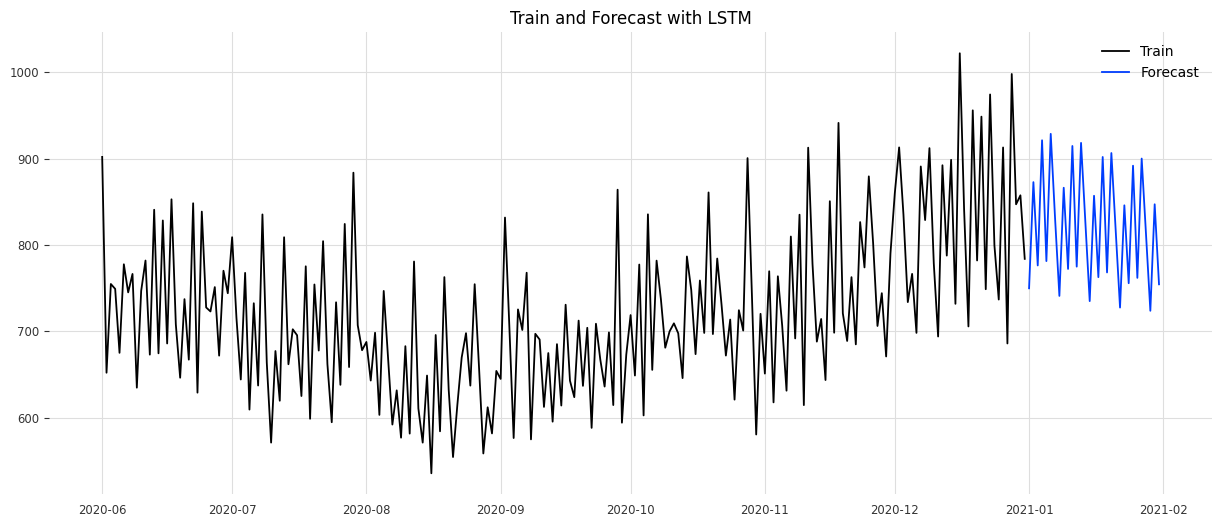

In [81]:
plot_future(df['y']['2020-06':], predictions, 'LSTM')